- The municipal wells (blue wells 1.6 cms, 0.8 each aquifer) have been in use for 10 years. 
- Stakeholders want to know the effects of additional proposed pumping 
- (red wells 0.3 cms each from upper aquifer).
- Determine the drawdowns and stream depletions that will occur  10 years after the proposed of pumping begins.
<img src="img/exercise1_conceptual_model_with_wells.png" width="400" height="500"/>

In [5]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists, expanduser
import glob

import pandas as pd
import numpy as np

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt


In [6]:
usr_dir = expanduser('~')
doc_dir = join(usr_dir, 'Documents')


In [7]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)



In [8]:
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
# if flopy exists on the computer elsewhere and not under GitHub it will be found as well
import flopy 

# Update the existing model

In [9]:
loadpth = 'C:/WRDAPP/GWFlowModel/training'
model_ws0 = join(loadpth, 'exercise_1')


In [10]:
m = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws0)
# update model_ws
model_ws = join(loadpth, 'exercise_1b')
m.model_ws = model_ws

In [11]:
m.get_package_list()

['DIS', 'BAS6', 'LPF', 'RIV', 'GHB', 'RCH', 'HOB', 'OC', 'PCG']

In [12]:
dis = m.dis
nrow = dis.nrow
ncol = dis.ncol
nlay = dis.nlay
delr = dis.delr
delc = dis.delc

In [13]:
# extract for easier referencing
top = m.dis.top.array
botm = m.dis.botm.array

## DIS redefinition

In [14]:
nper = 2
perlen = [1, 10*365*86400]
nstp = [1, 10]
steady = np.array([1,0]).astype(bool)

In [15]:
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(model=m,
                               nrow=nrow, ncol=ncol, nlay=nlay, 
                               delr=delr, delc=delc,
                               top=top, botm = botm,
                               lenuni = 2, itmuni = 1,
#                                rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
#                               start_datetime = strt_date
                              )

C:\Users\AndrewCalderwood.AzureAD\Documents/GitHub/flopy\flopy\mbase.py:628: UserWarning: Unit 11 of package DIS already in use.
  warn(
C:\Users\AndrewCalderwood.AzureAD\Documents/GitHub/flopy\flopy\mbase.py:637: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


## Check LPF
Need to define ss, sy because they are not needed in a steady state only model.

In [16]:
# load hydraulic parameter data
param = pd.read_excel('data/exercise1_hydraulic_parameters.xlsx', sheet_name='geologic', comment='#')


In [17]:
lpf = m.lpf

ss = np.zeros(m.dis.botm.shape)
sy = np.zeros(m.dis.botm.shape)
for k in np.arange(0,nlay):
    param_k = param[param.layer==k+1]
    ss[k] = param_k.loc[param_k.GroupName=='ss','StartValue']
    sy[k] = param_k.loc[param_k.GroupName=='sy','StartValue']
    
lpf.ss = ss
lpf.sy = sy

## WEL package

The municipal well pumps 0.8 cms per aquifer and is in cell (8,10) (1-based).  
The domestic wells pump 0.3 cms per well and are in cells (3:4,3:6) (1-based)

In [18]:
def get_layer_from_elev(elev, botm_slice):
    """  Return uppermost model layer (0-based) occupied at least partly by some elevation data
    It will return the bottom-most layer if an elevation is below the model
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    nlay = botm_slice.shape[0]
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))

In [19]:
## hypothetical example of more complex well data
# wcr = gpd.read_file('well.shp')
# grid = gpd.read_file('grid.shp')
# wcr_grid = gpd.sjoin(wcr, grid)

In [20]:
wel_data = pd.read_excel('data/exercise1_BC.xlsx', sheet_name='WEL', comment='#')


In [21]:
# option to demonstrate calculation of well layer by depth
# botm_slice = botm[:, wel_data.Row-1, wel_data.Column-1]
# wel_top_k = get_layer_from_elev(wel_data.Top_screen, botm_slice)
# wel_bot_k = get_layer_from_elev(wel_data.Bot_screen, botm_slice)

In [22]:
# assign pumping fluxes
wel_data['flux'] = -0
wel_data.loc[wel_data.Type=='Municipal', 'flux'] = -0.8
wel_data.loc[wel_data.Type=='Domestic', 'flux'] = -0.3

C:\Users\AndrewCalderwood.AzureAD\AppData\Local\Temp\ipykernel_27236\2219115945.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wel_data.loc[wel_data.Type=='Municipal', 'flux'] = -0.8


In [23]:
# adjust to python (1-based)
wel_out = wel_data.copy()
wel_out[['Layer','Row','Column']] -= 1 
# subset to values needed for input
wel_arr = wel_out[['Layer','Row','Column','flux']].values
# define dictionary of stress periods for flopy
wel_dict = {}
# pumping begins after the first stress period
wel_dict[1] = wel_arr

In [24]:
# intialize the well package
wel = flopy.modflow.ModflowWel(model=m, stress_period_data = wel_dict, ipakcb=53)

## Output Control udpate for new stress periods

In [25]:
# make a list of the combinations of stress periods and time steps
kstpkper = []
kperkstp = []
for n,stps in enumerate(nstp):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))
    kperkstp += list(zip(np.full(stps,n),np.arange(0,stps)))



In [26]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# create a default dictionary with output saved for all stress periods and steps
oc_dict = dict.fromkeys(kperkstp, ['save head','save budget', 'print budget'])

oc = flopy.modflow.ModflowOc(model = m, stress_period_data = oc_dict, compact = True)

C:\Users\AndrewCalderwood.AzureAD\Documents/GitHub/flopy\flopy\mbase.py:628: UserWarning: Unit 14 of package OC already in use.
  warn(
C:\Users\AndrewCalderwood.AzureAD\Documents/GitHub/flopy\flopy\mbase.py:637: UserWarning: Two packages of the same type, Replacing existing 'OC' package.
  warn(


# Run the Model

In [27]:
m.check()


MF MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Variable NRCHOP set to value other than 3

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: zero or negative specific s

In [28]:
# write the model input
m.write_input()


In [29]:
# run the model
success, buff = m.run_model()

FloPy is using the following executable to run the model: ..\..\..\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: MF.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/09/09 10:17:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    G

# Post-process

## Plot heads

In [30]:
# load the binary head output
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# we can extract the stress periods and times of output
kstpkper = hdobj.get_kstpkper()
times = hdobj.get_times()



In [31]:
head = hdobj.get_data(kstpkper=kstpkper[0])
# vmin = head.min()
# vmax = head.max()
vmin = 80
vmax = 190
print(vmin, vmax)

80 190


C:\Users\AndrewCalderwood.AzureAD\AppData\Local\Temp\ipykernel_27236\2864880880.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


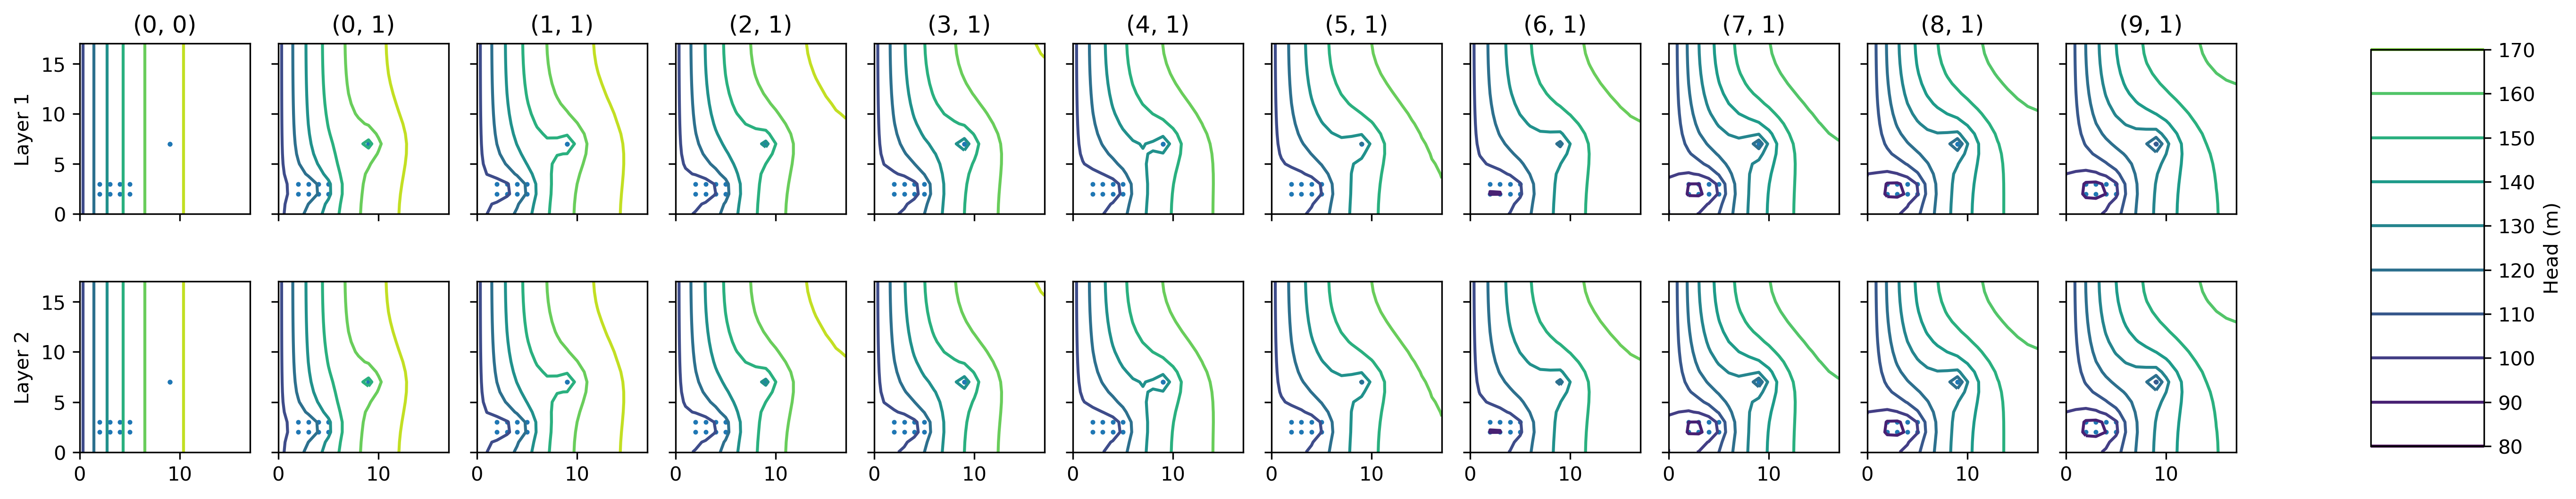

In [32]:

# fig,ax=plt.subplots(len(kstpkper),nlay, figsize=(4,16), sharex=True, sharey=True)
fig,ax=plt.subplots(nlay, len(kstpkper), figsize=(16,4), sharex=True, sharey=True, dpi=300)

for n in np.arange(0, len(kstpkper)):
    head = hdobj.get_data(kstpkper=kstpkper[n])
    # ax[n,0].set_ylabel(kstpkper[n])
    ax[0,n].set_title(kstpkper[n])
    for k in np.arange(0,head.shape[0]):
        # ax_n = ax[n, k]
        ax_n = ax[k,n]
        im = ax_n.contour(head[k], vmin=vmin, vmax=vmax)
        # add the locations of wells to the plot
        ax_n.scatter(wel_data.Column-1, wel_data.Row-1, s=2)
        ax_n.set_aspect(1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, shrink=0.7, label='Head (m)')
# ax[0,0].set_title('Layer 1')
# ax[0,1].set_title('Layer 2')
ax[0,0].set_ylabel('Layer 1')
ax[1,0].set_ylabel('Layer 2')
fig.tight_layout()

## Water budget

In [33]:
cbc = model_ws+'/MF.cbc'


In [34]:
def zone_clean(cbc,zon, kstpkper):
    zb = flopy.utils.ZoneBudget(cbc, zon, kstpkper)
    zb_df = zb.get_dataframes()
    # ungroup by timestep
    zb_df = zb_df.reset_index()
    names = zb_df.name.unique()
    zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')
    
    # columns to make negative
    to_cols = zb_df.columns[zb_df.columns.str.contains('TO_')]
    # multiply by -1 to have pulled out of water balance on plot
    zb_df.loc[:, to_cols] *= -1
    # correct for storage change
    # to storage is gw increase (positive)
    stor_cols = zb_df.columns[zb_df.columns.str.contains('STORAGE')]
    if len(stor_cols)>0:
        zb_df['dSTORAGE'] = (zb_df.TO_STORAGE + zb_df.FROM_STORAGE) * -1
        zb_df = zb_df.drop(columns=stor_cols)
    zb_df = zb_df.reset_index()
    return(zb_df)

In [35]:
zb_df = zone_clean(cbc, np.ones(m.dis.botm.shape, dtype=int), kstpkper)

In [36]:
mod_cols = zb_df.columns[zb_df.columns.str.contains('TO_|FROM_')].values
mod_cols = mod_cols[(np.abs(zb_df[mod_cols])>0).sum(axis=0).astype(bool)]


In [37]:
util_dir = join(doc_dir,'GitHub','gw_training','utilities')
fn = join(util_dir,'mf_wb_color_dict.xlsx')
zon_color_dict = pd.read_excel(fn, index_col='flux',comment='#', sheet_name='mf_wb_color_dict').color.to_dict()
zon_name_dict = pd.read_excel(fn,index_col='flux',comment='#', sheet_name='mf_wb_color_dict').name.to_dict()

Text(0, 0.5, 'Volumetric Flux ($m^3/s$)')

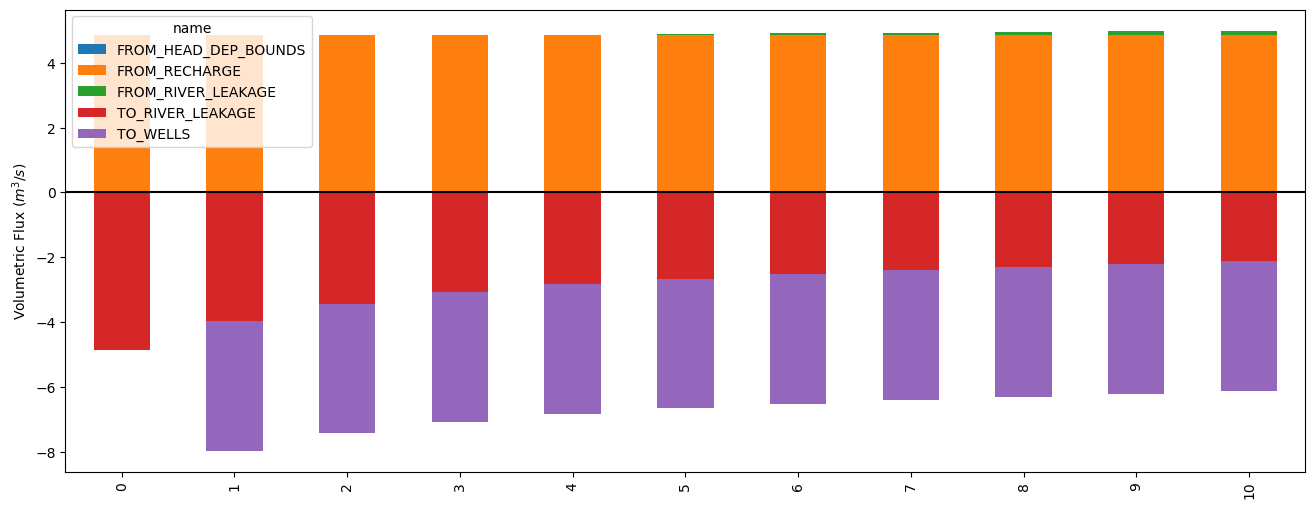

In [38]:
# convert m3 to AF
# zb_mod_all_AF = (all_mon*(1/0.3048**3)*(1/43560))

fig, ax = plt.subplots(figsize=(16,6))
# bar plot xticks are plotted as values
zb_df.plot(y=mod_cols,
           kind='bar',ax=ax, stacked = True,
#                color=[zon_color_dict[x] for x in mod_cols], 
#            label = [zon_name_dict[x] for x in mod_cols]
          )
ax.hlines(y=0, xmin = -100, xmax = 100, color = 'black')
plt.ylabel('Volumetric Flux ($m^3/s$)')

# lines are continuous xticks, either force datetime into strings or reuse previous xticks
# ax.plot(zb_mod_all_AF.index.astype(str), zb_mod_all_AF.dSTORAGE, color='black')
